# Imports

In [1]:
from imports import *
from hyperparameters import Hyperparameters
from trial_function import TrialFunction
from metropolis_sampler import MetropolisSampler

# Training procedure

In [2]:
def train(
    trialFunction: TrialFunction,
    hyperparameters: Hyperparameters
):
    """Trains trial function"""
    initialTime = time.time()
    timeHistory =  np.full(hyperparameters.numberOfTrainingSteps, np.nan)
    lossHistory = {
        'total loss' : np.full(hyperparameters.numberOfTrainingSteps, np.nan),
        'total squered residual' : np.full(hyperparameters.numberOfTrainingSteps, np.nan),
        'total normalisation error' : np.full(hyperparameters.numberOfTrainingSteps, np.nan),
        'total orthogonalisation error' : np.full(hyperparameters.numberOfTrainingSteps, np.nan)
    }
    eHistory = [None] * hyperparameters.numberOfTrainingSteps
    optimizer = torch.optim.AdamW(
        params=list(trialFunction.parameters()),
        lr=hyperparameters.initialLearningRate,
        weight_decay=hyperparameters.weightDecay,
    )
    lossFunction = nn.MSELoss()
    print(
        "Step, Time [s], Residual-term, Normalization-term,"
        + " Orthogonalization-term, Sorted energies"
    )
    for stepNumber in range(hyperparameters.numberOfTrainingSteps):
        if stepNumber == 0:
            sampler = MetropolisSampler(hyperparameters)
        else:
            for i in range(10):
                sampler.updateSampleBasOnDistrDens(trialFunction.weightFunction)
        # Loss function
        r = trialFunction.totalSqueredResidual(sampler.sample)
        a = trialFunction.totalNormalisationError(sampler.sample)
        b = trialFunction.totalOrthogonalisationError(sampler.sample)
        e = trialFunction.spectrum(sampler.sample)
        loss = lossFunction(
            hyperparameters.residualTermWeight * r
            + hyperparameters.normalisationTermWeight * a
            + hyperparameters.orthogonalisationTermWeight * b
            + hyperparameters.energyTermWeight * torch.sum(e),
            torch.tensor(0.0).to(hyperparameters.device),
        )
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save some history
        timeHistory[stepNumber] = time.time() - initialTime
        if np.isnan(loss.item()):
            torch.save(trialFunc.state_dict(), trialFunc.PATH)
            print("LOSS IS NAN (model has been saved)")
            sys.exit(1)
        lossHistory['total loss'][stepNumber] = loss.item()
        lossHistory['total squered residual'][stepNumber] = r.cpu().detach().numpy()
        lossHistory['total normalisation error'][stepNumber] = a.cpu().detach().numpy()
        lossHistory['total orthogonalisation error'][stepNumber] = b.cpu().detach().numpy()
        eHistory[stepNumber] = e.cpu().detach().numpy()
        # Release some memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        # Print the state of the model
        if stepNumber % 500 == 0:
            print(
                f"{stepNumber},"
                + f" {timeHistory[stepNumber]:.2f},"
                + f" {r.cpu().detach().numpy():.4e},"
                + f" {a.cpu().detach().numpy():.4e}," 
                + f" {b.cpu().detach().numpy():.4e},"
                + f" {np.sort(eHistory[stepNumber])}"
            )
    timeHistoryDF = pd.DataFrame(data={'time [s]' : timeHistory})
    lossHistoryDF = pd.DataFrame(data=lossHistory)
    eHistoryDF = pd.DataFrame(data=eHistory)
    return timeHistoryDF, lossHistoryDF, eHistoryDF     

# 3D

## Hyperparameters

In [3]:
hyperparameters_3d = Hyperparameters("../hyperparameters/hyperparameters_3d.csv")
pd.read_csv("../hyperparameters/hyperparameters_3d.csv")

,name,value
0,activation function,sin
1,amplitude function,gaussian
2,hidden layer size,100
3,coordinate space dimension,3
4,number of states,5
5,batch size,8192
6,initial learning rate,0.001
7,weight decay,0.001
8,residual term weight,1.0
9,normalisation term weight,1.0


## Tests

In [4]:
numberOfTests = 3
trialFunction_3D = [None] * numberOfTests
timeHistory = [None] * numberOfTests
lossHistory = [None] * numberOfTests
eHistory = [None] * numberOfTests

for testNumber in range(numberOfTests):
    print(f"Test {testNumber}")
    trialFunction_3D[testNumber] = TrialFunction(
        hyperparameters_3d,
        f"3d_{testNumber}"
    )
    timeHistory[testNumber], lossHistory[testNumber], eHistory[testNumber] = train(
        trialFunction_3D[testNumber],
        hyperparameters_3d
    )
    torch.save(
        trialFunction_3D[testNumber].state_dict(), 
        trialFunction_3D[testNumber].PATH
    )
    timeHistory[testNumber].to_csv(f"../loss/time_3d_{testNumber}.csv")
    lossHistory[testNumber].to_csv(f"../loss/loss_3d_{testNumber}.csv")
    eHistory[testNumber].to_csv(f"../loss/e_3d_{testNumber}.csv")

Test 0
Step, Time [s], Residual-term, Normalization-term, Orthogonalization-term, Sorted energies
0, 3.90, 6.4356e+03, 2.0618e-03, 3.1289e-02, [28.44836  28.88348  29.835968 31.583677 39.89724 ]
500, 129.82, 1.2041e+02, 4.6760e-01, 1.5775e-02, [2.017074  5.3965654 5.7603507 7.0030456 7.3834476]
1000, 257.04, 6.7027e+01, 4.5768e-01, 8.3870e-03, [1.7485675 4.1275578 4.4270616 5.3594646 6.1666536]
1500, 377.19, 4.3543e+01, 5.1716e-01, 4.3314e-03, [1.6666414 3.600773  3.9073644 4.4950647 5.539529 ]
2000, 510.47, 3.3068e+01, 5.6210e-01, 4.3461e-03, [1.6343197 3.3897352 3.5693772 4.013681  5.129026 ]
2500, 637.04, 2.4917e+01, 6.0380e-01, 2.1569e-03, [1.5953466 3.1790085 3.4209757 3.6985626 4.8585925]
3000, 767.19, 2.0907e+01, 6.6394e-01, 3.6166e-03, [1.5654343 3.1337333 3.1931665 3.5138812 4.61566  ]
3500, 895.82, 1.8318e+01, 7.2530e-01, 2.7390e-03, [1.5828035 3.071481  3.0777652 3.3197045 4.572573 ]
4000, 1029.73, 1.5035e+01, 7.8108e-01, 2.6515e-03, [1.5524422 2.969824  3.0311973 3.172908  

In [5]:
lossHistory[0].columns

Index(['total loss', 'total squered residual', 'total normalisation error',
       'total orthogonalisation error'],
      dtype='object')

Text(0.5, 0, 'Iteration number')

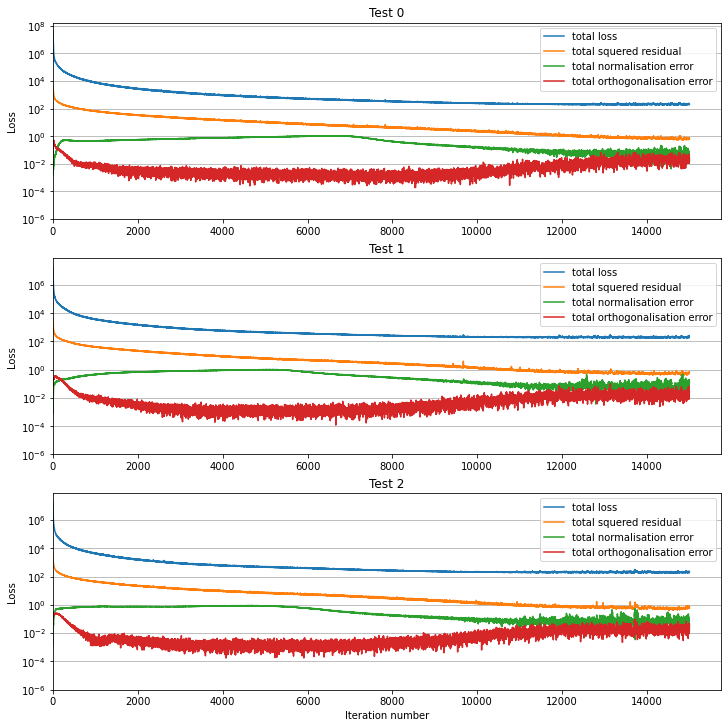

In [11]:
fig, axes = plt.subplots(numberOfTests, 1, figsize=(10,10), layout='constrained')

for testNumber, ax in enumerate(axes):
    lossHistory[testNumber].plot(ax=ax)
    ax.set_yscale('log')
    ax.grid(axis='y')
    ax.set_ylim(1e-6,None)
    ax.set_xlim(0,None)
    ax.set_ylabel('Loss')
    ax.set_title(f"Test {testNumber}")
plt.xlabel('Iteration number')


Text(0.5, 0, 'Iteration number')

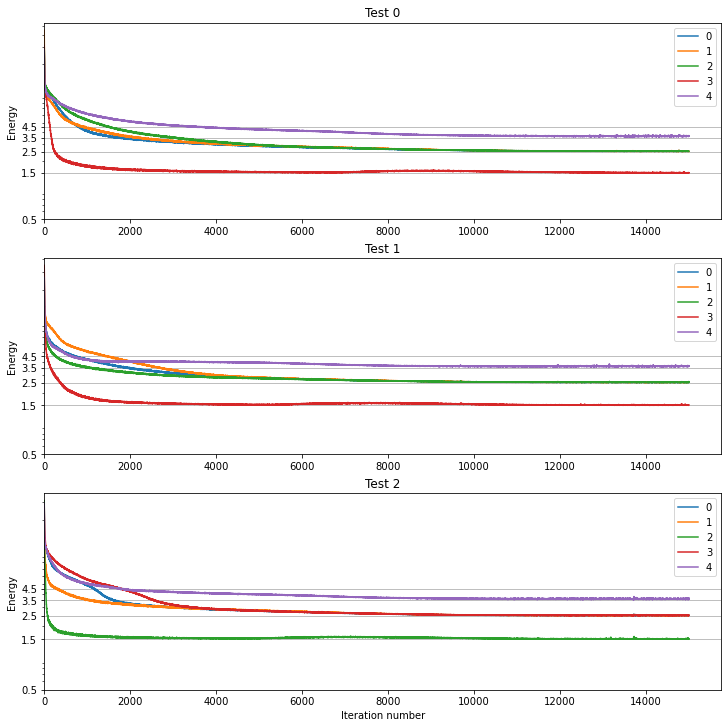

In [16]:
fig, axes = plt.subplots(numberOfTests, 1, figsize=(10,10), layout='constrained')

for testNumber, ax in enumerate(axes):
    eHistory[testNumber].plot(ax=ax)
    ax.set_yscale('log')
    ax.grid(axis='y')
    ax.set_ylim(1,None)
    ax.set_xlim(0,None)
    ax.set_ylabel('Energy')
    ax.set_title(f"Test {testNumber}")
    ax.set_yticks(np.arange(0.5,5.5,1))
    ax.set_yticklabels(np.arange(0.5,5.5,1))
    
plt.xlabel('Iteration number')


<AxesSubplot:xlabel='time [s]', ylabel='Energy'>

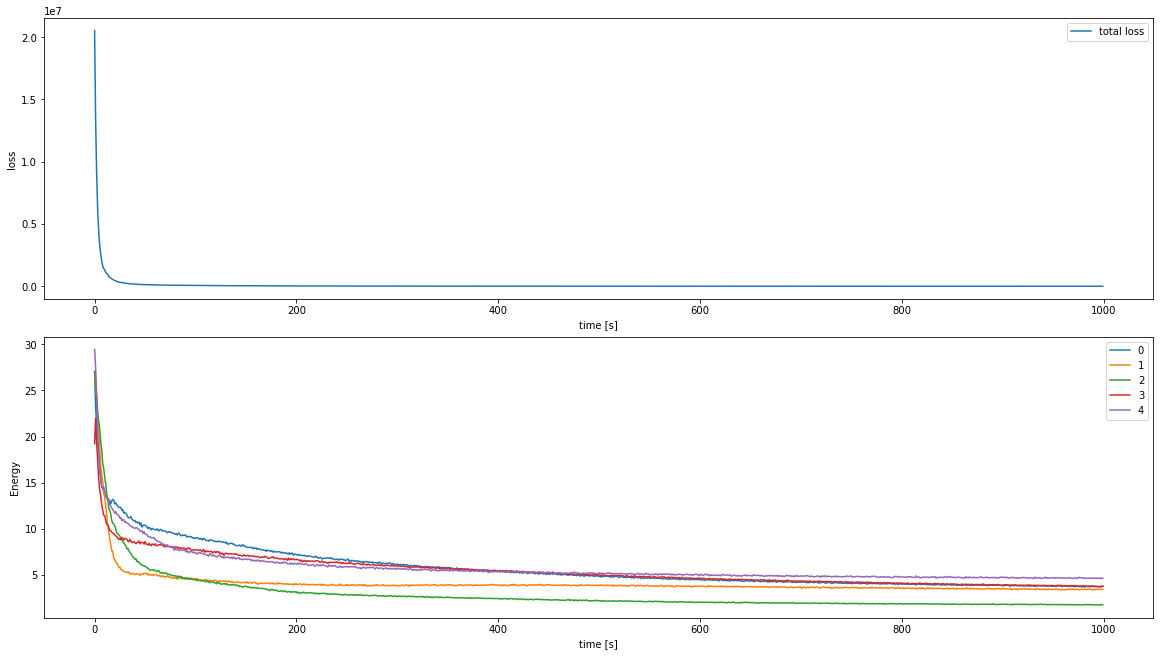

In [7]:
fig = plt.figure(figsize=(16,9), layout='constrained')

ax = fig.add_subplot(2,1,1)
lossHistory.plot(
    ax=ax,
    # xlim=(0,15000),
    xlabel='time [s]',
    ylabel='loss'
)
# ax.set_xticks(list(range(15001))[::1000])
# ax.set_xticklabels(timeHistory['time [s]'].to_numpy()[::1000], rotation=-45)

ax = fig.add_subplot(2,1,2)
eHistory.plot(
    ax=ax,
    # xlim=(0,15000),
    xlabel='time [s]',
    ylabel='Energy'
)
# ax.set_xticks(list(range(15001))[::1000])
# ax.set_xticklabels(timeHistory['time [s]'].to_numpy()[::1000], rotation=-45)

In [ ]:
trialFunction = TrialFunction(
    hyperparameters,
    "3d_2"
)

timeHistory, lossHistory, eHistory = train(
    trialFunction,
    hyperparameters
)

torch.save(trialFunction.state_dict(), trialFunction.PATH)

In [ ]:
trialFunction = TrialFunction(
    hyperparameters,
    "3d_3"
)

timeHistory, lossHistory, eHistory = train(
    trialFunction,
    hyperparameters
)

torch.save(trialFunction.state_dict(), trialFunction.PATH)

In [11]:
params = [None] * 8
j = 0
for i in (list(trialFunction_3D_1.parameters())):
    params[j]=list(i.detach().cpu().numpy().reshape(-1))
    j = j+1
    print(type(i), i.shape)

<class 'torch.nn.parameter.Parameter'> torch.Size([100, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([100])
<class 'torch.nn.parameter.Parameter'> torch.Size([100, 100])
<class 'torch.nn.parameter.Parameter'> torch.Size([100])
<class 'torch.nn.parameter.Parameter'> torch.Size([100, 100])
<class 'torch.nn.parameter.Parameter'> torch.Size([100])
<class 'torch.nn.parameter.Parameter'> torch.Size([5, 100])
<class 'torch.nn.parameter.Parameter'> torch.Size([5])


1.2905197 -1.1178716
0.89640284 -1.0523361


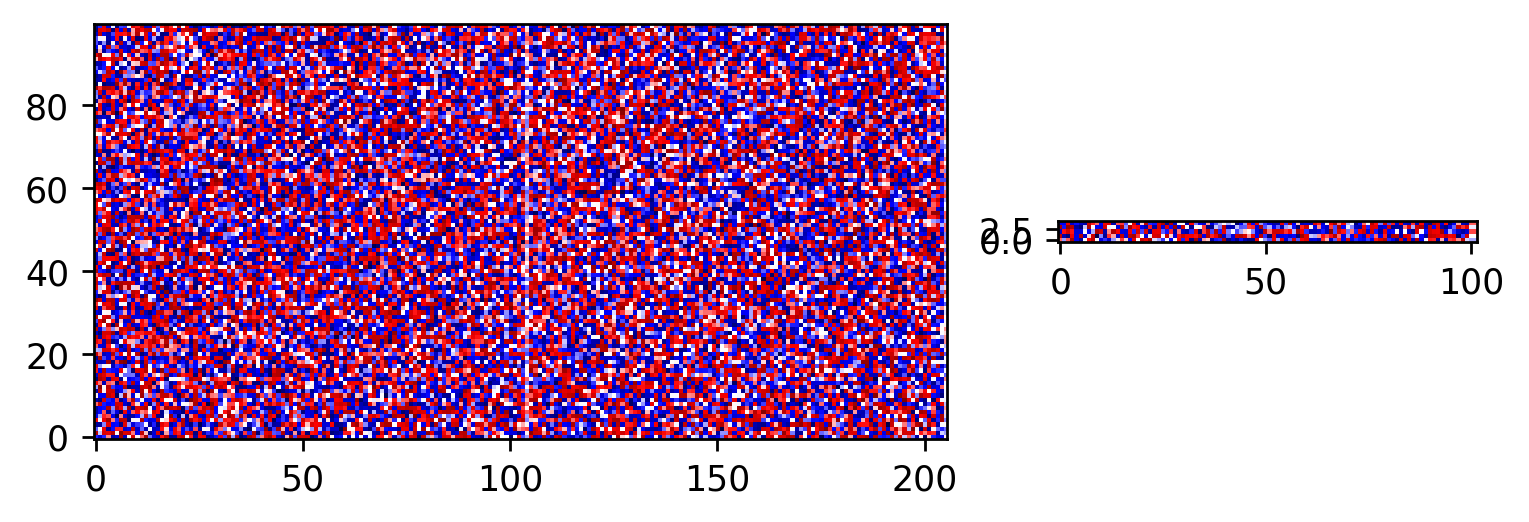

In [13]:
fig = plt.figure(layout='constrained', dpi=250)

gs = fig.add_gridspec(100,4+101+101+101)

from matplotlib import colors
# ax[1] = fig.add_subplot(gs[:,4:4+101])
# ax[2] = fig.add_subplot(gs[:,4+101:4+101+101])


a = []
for i in range(6):
    a.extend(params[i])
print(max(a), min(a))
ax = fig.add_subplot(gs[:,:4+101+101])
ax.imshow(
    np.array(a).reshape(-1,100).transpose(),
    origin='lower',
    cmap='seismic',
    # vmax=1,vmin=-1,
    norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-1.0, vmax=1.0, base=10),
)

a = params[6]
a.extend(params[7])
print(max(a), min(a))

ax = fig.add_subplot(gs[:,4+101+101:])
ax.imshow(
    np.array(a).reshape(-1,5).transpose(),
    origin='lower',
    cmap='seismic',
    # vmax=1,vmin=-1,
    norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-1.0, vmax=1.0, base=10),
)

In [11]:
list(trialFunction.parameters())[0].shape

torch.Size([100, 3])

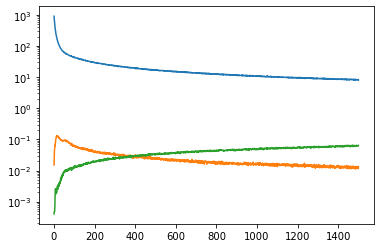

In [19]:
plt.plot(lossHistory['total squered residual'])
plt.plot(lossHistory['total orthogonalisation error'])
plt.plot(lossHistory['total normalisation error'])
plt.yscale("log")

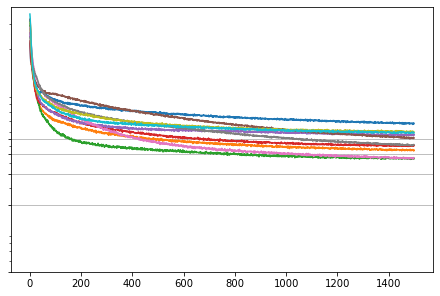

In [20]:
fig, ax = plt.subplots(1,1,layout='constrained')

ax.plot(eHistory)
ax.set_yscale("log")
ax.set_yticks([0.5,1.5,2.5,3.5,4.5])
ax.grid(axis='y')
# ax.set_xticks(list(range(15001))[::1000])
# ax.set_xticklabels(list(range(15001))[::1000], rotation=-45)

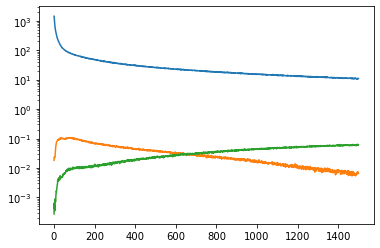

In [12]:
plt.plot(lossHistory['total squered residual'])
plt.plot(lossHistory['total orthogonalisation error'])
plt.plot(lossHistory['total normalisation error'])
plt.yscale("log")

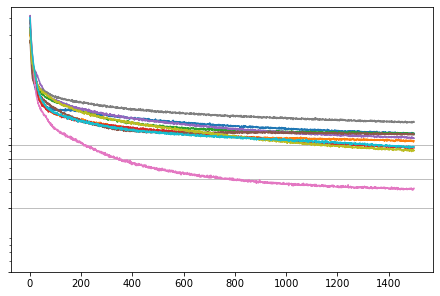

In [15]:
fig, ax = plt.subplots(1,1,layout='constrained')

ax.plot(eHistory)
ax.set_yscale("log")
ax.set_yticks([0.5,1.5,2.5,3.5,4.5])
ax.grid(axis='y')
# ax.set_xticks(list(range(15001))[::1000])
# ax.set_xticklabels(list(range(15001))[::1000], rotation=-45)